In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

In [2]:
data = pd.ExcelFile('HW3Covid.xlsx')

<h1> Splitting sheets for Excel File </h1>

In [6]:
# covid_data = {}
# for sheet in data.sheet_names:
#     covid_data[sheet] = data.parse(sheet)

brazil_data = data.parse('Brazil Covid-19 data')
temp = data.parse('Temperature by State')
state_stats = data.parse('Brazil State Stats')
city_area = data.parse('City area')

<h2> Filtering out all the non capitol cities

In [24]:
# Inner join with the temperature dataframe consisting of annual temperatures based on two keys (city, state_abbreviation)
# for getting the temperature and also filtering out non capitol cities using the flag IS_CAPITOL

final_dataset = pd.merge(brazil_data, temp[['CITY','IS_CAPITOL', 'STATE_ABBR', 'ANNUAL']], left_on = ['Municipality', 'State'] ,
                         right_on = ['CITY', 'STATE_ABBR'], how = 'inner')

#Dropping Sao Paolo from the dataset as the paper also does the same
final_dataset = final_dataset.drop(final_dataset.query('Municipality == "São Paulo"').index)

final_dataset['Population as of 2019'] = final_dataset['Population as of 2019'].astype(float)

#choosing only capitol cities from the dataset
final_dataset = final_dataset[final_dataset['IS_CAPITOL'].str.lower() == 'y']

<h2> Converting Fahrenheit to celcius

In [25]:
final_dataset['temp'] =  (final_dataset['ANNUAL'] - 32) * 5 / 9

<h2> Merge on State Stats for getting the area of the city

In [26]:
final_dataset = pd.merge(final_dataset, city_area, left_on = 'State', right_on = 'ST', how = 'inner')

<h2> Calculation popluation density for a city

In [27]:
final_dataset['density'] = final_dataset['Population as of 2019'] / final_dataset['SQ_KM']

<h2> Calculating Count Days </h2>

Here I create a dictionay of dataframes split by individual municipality names by the following steps: 
<ol>
    <li> Check the last occurence of 0 for <i>Accumulated cases</i> on each dataframe and mark the index</li>
    <li> Mark the index of last occurence date and add 1 to get the row for the inception date and store that to <i> inception_date </i> variable </li>
    <li> Subtract inception date from the current date for each row and get the count days for each city </li>
    <li> Append all the dataframes back to the <i> final_dataset </i> variable

In [28]:
dataframes_by_municipality = {}
for i in final_dataset.Municipality:
    dataframes_by_municipality[i] = final_dataset[final_dataset['Municipality'] == i]

In [31]:
final_dataset = pd.DataFrame()
for key in dataframes_by_municipality:
    municipality_under_operation = dataframes_by_municipality[key]
    covid_inception_index = municipality_under_operation.where(municipality_under_operation['Accumulated cases'] == 0).last_valid_index()    
    inception_date = municipality_under_operation.loc[covid_inception_index + 1].Date
    municipality_under_operation['countdays'] = pd.to_datetime(municipality_under_operation.Date).sub(pd.Timestamp(inception_date)).dt.days
    final_dataset = final_dataset.append(municipality_under_operation)

In [55]:
#generating features for the GAM
final_dataset['countdays^2'] = final_dataset['countdays'] ** 2
final_dataset['countdays^3'] = final_dataset['countdays'] ** 3
final_dataset['density^2'] = final_dataset['density'] ** 2

#dropping 0 values for Accumulated cases as log of 0 will give infinity which breaks the regression
final_dataset = final_dataset.drop(final_dataset[final_dataset['Accumulated cases'] == 0].index)

x = final_dataset[['countdays^3','countdays^2','countdays', 'temp', 'density^2', 'density', 'Population as of 2019']]
y = final_dataset['Accumulated cases']
y = np.log(y)
final_dataset

,Region,State,Municipality,State-code,Municipality-code,Health-region-code,Health-region-name,Date,Week #,Population as of 2019,...,ANNUAL,temp,ST,City,SQ_KM,density,countdays,countdays^2,countdays^3,density^2
1,Norte,RO,Porto Velho,11,110020.0,11004.0,MADEIRA-MAMORE,2020-03-28,13,529544.0,...,78.1,25.611111,RO,Porto Velho,34091.0,15.533249,0,0,0,241.281832
2,Norte,RO,Porto Velho,11,110020.0,11004.0,MADEIRA-MAMORE,2020-03-29,14,529544.0,...,78.1,25.611111,RO,Porto Velho,34091.0,15.533249,1,1,1,241.281832
3,Norte,RO,Porto Velho,11,110020.0,11004.0,MADEIRA-MAMORE,2020-03-30,14,529544.0,...,78.1,25.611111,RO,Porto Velho,34091.0,15.533249,2,4,8,241.281832
4,Norte,RO,Porto Velho,11,110020.0,11004.0,MADEIRA-MAMORE,2020-03-31,14,529544.0,...,78.1,25.611111,RO,Porto Velho,34091.0,15.533249,3,9,27,241.281832
5,Norte,RO,Porto Velho,11,110020.0,11004.0,MADEIRA-MAMORE,2020-04-01,14,529544.0,...,78.1,25.611111,RO,Porto Velho,34091.0,15.533249,4,16,64,241.281832
6,Norte,RO,Porto Velho,11,110020.0,11004.0,MADEIRA-MAMORE,2020-04-02,14,529544.0,...,78.1,25.611111,RO,Porto Velho,34091.0,15.533249,5,25,125,241.281832
7,Norte,RO,Porto Velho,11,110020.0,11004.0,MADEIRA-MAMORE,2020-04-03,14,529544.0,...,78.1,25.611111,RO,Porto Velho,34091.0,15.533249,6,36,216,241.281832
8,Norte,RO,Porto Velho,11,110020.0,11004.0,MADEIRA-MAMORE,2020-04-04,14,529544.0,...,78.1,25.611111,RO,Porto Velho,34091.0,15.533249,7,49,343,241.281832
9,Norte,RO,Porto Velho,11,110020.0,11004.0,MADEIRA-MAMORE,2020-04-05,15,529544.0,...,78.1,25.611111,RO,Porto Velho,34091.0,15.533249,8,64,512,241.281832
10,Norte,RO,Porto Velho,11,110020.0,11004.0,MADEIRA-MAMORE,2020-04-06,15,529544.0,...,78.1,25.611111,RO,Porto Velho,34091.0,15.533249,9,81,729,241.281832


<h2> Descriptive statistics for all the feature variables </h2>

In [35]:
x.describe(include = 'all')

,countdays^3,countdays^2,countdays,temp,density^2,density,Population as of 2019
count,3.900000e+03,3900.000000,3900.00000,3900.000000,3.900000e+03,3900.000000,3.900000e+03
mean,8.325375e+05,7425.166667,74.50000,24.497863,1.325948e+07,2562.350339,1.457235e+06
std,9.469043e+05,6666.955597,43.30586,2.707504,1.982095e+07,2587.578097,1.330655e+06
min,0.000000e+00,0.000000,0.00000,16.777778,2.412818e+02,15.533249,2.991270e+05
25%,5.065300e+04,1369.000000,37.00000,23.222222,3.462256e+04,186.071385,5.295440e+05
50%,4.135495e+05,5550.500000,74.50000,25.444444,2.980780e+06,1701.537486,9.574650e+05
75%,1.404928e+06,12544.000000,112.00000,26.611111,1.713978e+07,4140.021620,1.933105e+06
max,3.307949e+06,22201.000000,149.00000,27.777778,7.236067e+07,8506.507330,6.718903e+06


<h2> Correlation matrix for all the regressors </h2>
In the correlation matrix, we can see that temp is not correlated with any of the other variables under study. 

In [37]:
x.corr()

,countdays^3,countdays^2,countdays,temp,density^2,density,Population as of 2019
countdays^3,1.000000e+00,9.859699e-01,9.158446e-01,-3.670861e-17,2.455466e-18,-5.230926e-17,0.000000e+00
countdays^2,9.859699e-01,1.000000e+00,9.678440e-01,1.633418e-17,6.444268e-17,-2.575365e-17,1.171220e-16
countdays,9.158446e-01,9.678440e-01,1.000000e+00,1.765629e-17,-9.830933e-18,-3.130795e-18,0.000000e+00
temp,-3.670861e-17,1.633418e-17,1.765629e-17,1.000000e+00,-5.348629e-02,-1.370117e-01,-2.008263e-01
density^2,2.455466e-18,6.444268e-17,-9.830933e-18,-5.348629e-02,1.000000e+00,9.489092e-01,4.206915e-01
density,-5.230926e-17,-2.575365e-17,-3.130795e-18,-1.370117e-01,9.489092e-01,1.000000e+00,4.621536e-01
Population as of 2019,0.000000e+00,1.171220e-16,0.000000e+00,-2.008263e-01,4.206915e-01,4.621536e-01,1.000000e+00


<h2> Regression Class to accept lasso, linear or ridge regression </h2>

In [292]:
class RegressionModel():    
    def __init__(self, linear_model):
        self.model = linear_model        
    
    def fit_model(self, x, y):
        self.x = x
        self.y = y
        
        self.model.fit(x, y)
        return self.model
    
    def plot_graph(self):
        %matplotlib inline
        temps = np.linspace(1, 40, 1000)
        x_controlled = np.ones((1000,7))

        for i in range(0,1000):
            x_controlled[i][3] = temps[i]   

        f_temp = self.model.predict(x_controlled)
       
        plt.plot(temps, f_temp)
        plt.xlabel('temperature')
        plt.ylabel('f(temperature)')
        plt.title('temp vs f(temp) graph')
        
    def provide_coefficients(self):
        coefficient_df = pd.DataFrame()
        coefficient_df[''] = x.columns
        coefficient_df['Values'] = self.model.coef_
        coefficient_df = coefficient_df.set_index('')
        coefficient_df

        print("Intercept value ::", self.model.intercept_)
        return(coefficient_df)      
    
    def r_squared(self):
        return self.model.score(self.x, self.y)
        
    def __del__(self): 
        return 0

<h2> Linear regression for all the features </h2>

In [293]:
linear_regression = RegressionModel(LinearRegression())
linear_regression.fit_model(x, y)
linear_regression.provide_coefficients()

Intercept value :: -0.49773611104513016


,Values
,
countdays^3,1.718703e-06
countdays^2,-7.024645e-04
countdays,1.116829e-01
temp,1.273383e-01
density^2,2.089998e-09
density,4.287574e-05
Population as of 2019,5.001414e-07


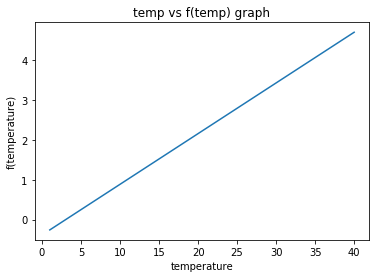

In [294]:
linear_regression.plot_graph()

In [295]:
print("R squared value for the linear model is",linear_regression.r_squared())

R squared value for the linear model is 0.8841460169320968


In [302]:
%%javascript
    IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

<h2> Lasso Regression </h2>

Alpha :  0.0001
R-Squared : 0.8805244884541948



C:\Users\Bikal\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


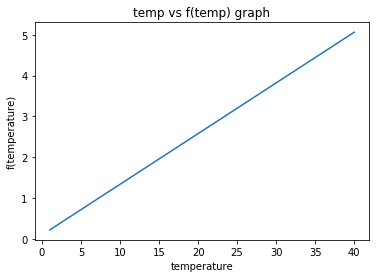

Alpha :  0.001
R-Squared : 0.8532127562433017



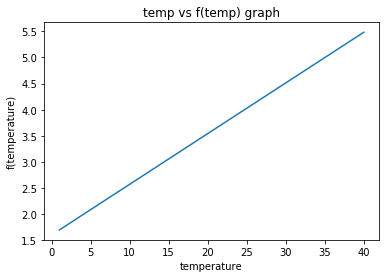

Alpha :  0.01
R-Squared : 0.6231573878525727



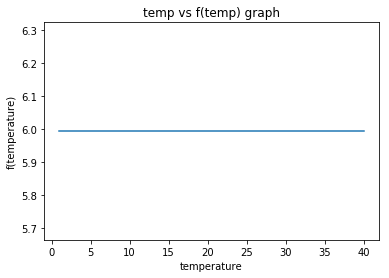

Alpha :  0.1
R-Squared : 0.0



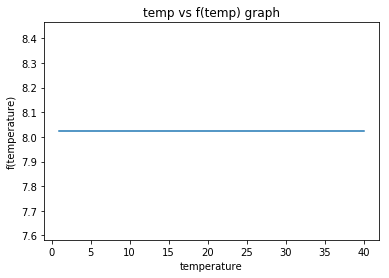

Alpha :  1
R-Squared : 0.0



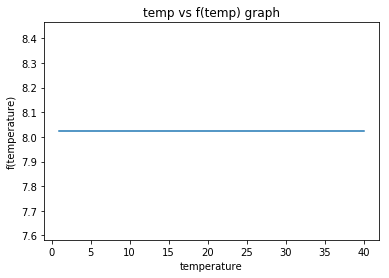

Alpha :  10
R-Squared : 0.0



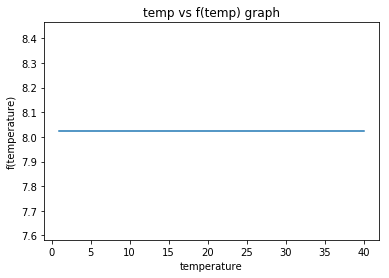

In [303]:
from sklearn import linear_model

alpha_values = [0.0001, 0.001, 0.01, 0.1 , 1, 10]

for a in alpha_values:
    lasso_model = RegressionModel(linear_model.Lasso(alpha = a, normalize=True))
    lasso_model.fit_model(x, y)
    lasso_model.plot_graph()
    print("Alpha : ", a,)
    print('R-Squared :', lasso_model.r_squared())
    print()
    plt.show()

<h2> Ridge Regression </h2>

Alpha :  0.0001
R-Squared : 0.8840858991960067



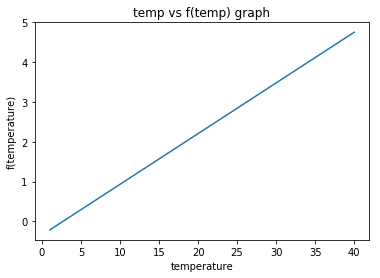

Alpha :  0.001
R-Squared : 0.8820945626864578



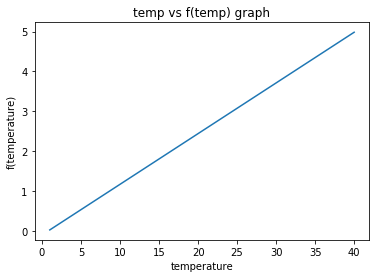

Alpha :  0.01
R-Squared : 0.8746677873775093



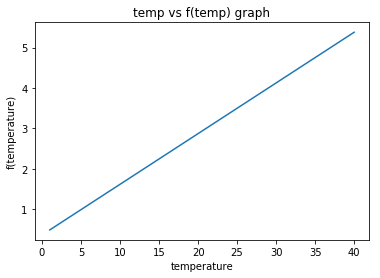

Alpha :  0.1
R-Squared : 0.8228268340696866



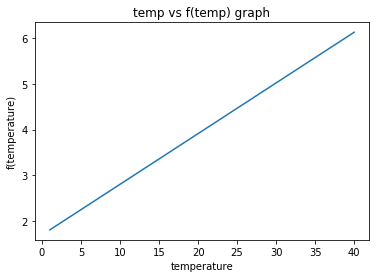

Alpha :  1
R-Squared : 0.6613308015910371



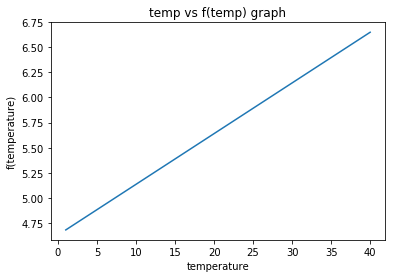

Alpha :  10
R-Squared : 0.26193420332217543



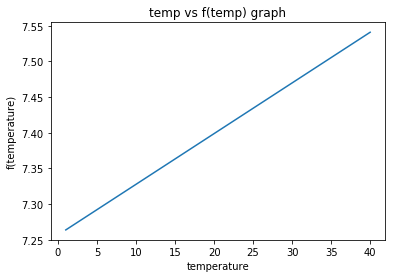

In [304]:
alpha_values = [0.0001, 0.001, 0.01, 0.1 , 1, 10]

for a in alpha_values:
    ridge_model = RegressionModel(linear_model.Ridge(alpha = a, normalize=True))
    ridge_model.fit_model(x, y)
    ridge_model.plot_graph()
    print("Alpha : ", a)
    print('R-Squared :', ridge_model.r_squared())    
    print()
    plt.show()

<h2> Polynomial fit for just temperature with degree 3 </h2>

To use an alternate model, I am going to fit a polynomial model with degree 3 for just the feature temperature

In [345]:
z = np.poly1d(np.polyfit(x['temp'],y,3))
predict = np.poly1d(z)

In [346]:
temps_for_poly = np.linspace(1,40,100)
y_predicted = predict(temps_for_poly)

Text(0.5,1,'temp vs f(temp) graph')

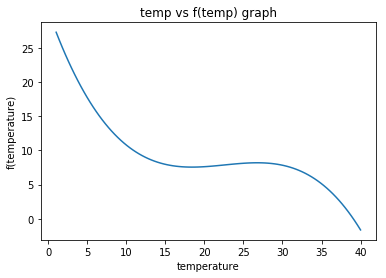

In [347]:
plt.plot(temps_for_poly, y_predicted)
plt.xlabel('temperature')
plt.ylabel('f(temperature)')
plt.title('temp vs f(temp) graph')


After running linear, lasso and ridge regression, the <b> r_squared value of linear regression was the highest with 0.8841 </b>. The results obtained here do not agree with the papers results. In contrast, after controlling for other variables, the f(temp) seemed to be positively associated to temperature as opposed to the paper's results. The graphs look identical for linear, lasso and ridge even after changing the values of alpha with just changing y value ranges.

Running a polynomial model with only the temperature feature showed a downard trend which is the complete opposite of the trend while considering all the other features with the Generalized Additive model.